In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
import sklearn.metrics as metrics


In [7]:
df = pd.read_csv('train.csv')
df.head()

,ID,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,2010,EPX,Travel Agency,Online,Cancellation Plan,61,PHILIPPINES,12.0,0.00,41,0
1,4245,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,17.0,0.00,35,0
2,9251,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,26,THAILAND,19.8,11.88,47,0
3,4754,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,HONG KONG,27.0,0.00,48,0
4,8840,EPX,Travel Agency,Online,2 way Comprehensive Plan,15,MALAYSIA,37.0,0.00,36,0


In [11]:
df.drop('ID', axis=1, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52310 entries, 0 to 52309
Data columns (total 10 columns):
Agency                  52310 non-null object
Agency Type             52310 non-null object
Distribution Channel    52310 non-null object
Product Name            52310 non-null object
Duration                52310 non-null int64
Destination             52310 non-null object
Net Sales               52310 non-null float64
Commision (in value)    52310 non-null float64
Age                     52310 non-null int64
Claim                   52310 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB


In [13]:
df.describe()

,Duration,Net Sales,Commision (in value),Age,Claim
count,52310.000000,52310.000000,52310.000000,52310.000000,52310.000000
mean,58.256108,48.554673,12.219963,39.555725,0.166699
std,109.138708,60.198589,22.847645,13.762473,0.372710
min,-2.000000,-389.000000,0.000000,0.000000,0.000000
25%,10.000000,19.800000,0.000000,33.000000,0.000000
50%,24.000000,29.500000,0.000000,36.000000,0.000000
75%,57.000000,55.000000,13.380000,43.000000,0.000000
max,4881.000000,682.000000,262.760000,118.000000,1.000000


In [14]:
df.loc[df['Duration'] < 0, 'Duration'] = 58

In [16]:

# Function to identify numeric features
def numeric_features(dataset):
    numeric_col = dataset.select_dtypes(include=np.number).columns.tolist()
    return dataset[numeric_col].head()

numeric_columns = numeric_features(df)
print("Numeric Features:")
print(numeric_columns)
print("===="*20)



# Function to identify categorical features
def categorical_features(dataset):
    categorical_col = dataset.select_dtypes(exclude=np.number).columns.tolist()
    return dataset[categorical_col].head()

categorical_columns = categorical_features(df)
print("Categorical Features:")
print(categorical_columns)


# Function to check the datatypes of all the columns:
def check_datatypes(dataset):
    
    return dataset.dtypes


check_datatypes(df)


Numeric Features:
   Duration  Net Sales  Commision (in value)  Age  Claim
0        61       12.0                  0.00   41      0
1         4       17.0                  0.00   35      0
2        26       19.8                 11.88   47      0
3        15       27.0                  0.00   48      0
4        15       37.0                  0.00   36      0
Categorical Features:
  Agency    Agency Type Distribution Channel                     Product Name  \
0    EPX  Travel Agency               Online                Cancellation Plan   
1    EPX  Travel Agency               Online                Cancellation Plan   
2    CWT  Travel Agency               Online  Rental Vehicle Excess Insurance   
3    EPX  Travel Agency               Online         2 way Comprehensive Plan   
4    EPX  Travel Agency               Online         2 way Comprehensive Plan   

   Destination  
0  PHILIPPINES  
1     MALAYSIA  
2     THAILAND  
3    HONG KONG  
4     MALAYSIA  


Agency                   object
Agency Type              object
Distribution Channel     object
Product Name             object
Duration                  int64
Destination              object
Net Sales               float64
Commision (in value)    float64
Age                       int64
Claim                     int64
dtype: object

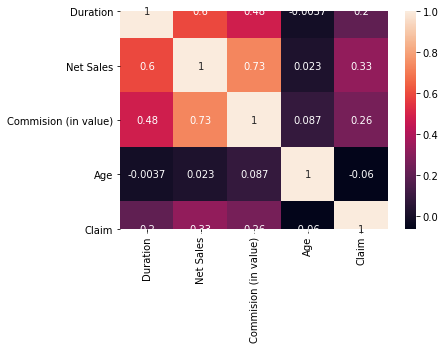

In [19]:
# Numerical values correlation
sns.heatmap(df.corr(), annot=True)

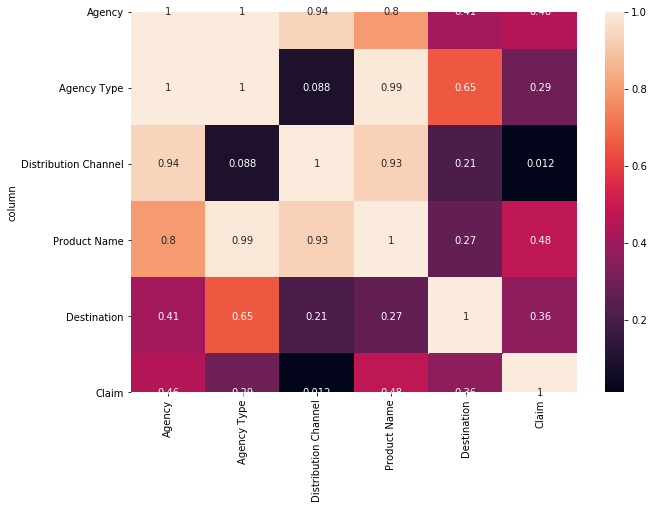

In [23]:
# Categorical columns correlation
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

categorical=['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',  'Destination','Claim']
cramers=pd.DataFrame({i:[cramers_v(df[i],df[j]) for j in categorical] for i in categorical})
cramers['column']=[i for i in categorical if i not in ['memberid']]
cramers.set_index('column',inplace=True)

#categorical correlation heatmap

plt.figure(figsize=(10,7))
sns.heatmap(cramers,annot=True)
plt.show()

In [47]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, df):
        self.df = df
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = ss.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)
        
X = df.drop(['Claim'], axis=1)
ct = ChiSquare(df)
for c in X.columns:
    ct.TestIndependence(c, 'Claim')

Agency is IMPORTANT for Prediction
Agency Type is IMPORTANT for Prediction
Distribution Channel is IMPORTANT for Prediction
Product Name is IMPORTANT for Prediction
Duration is IMPORTANT for Prediction
Destination is IMPORTANT for Prediction
Net Sales is IMPORTANT for Prediction
Commision (in value) is IMPORTANT for Prediction
Age is IMPORTANT for Prediction


In [53]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Function that auto encodes any dataframe column of type category or object.
def dummyEncode(dataset):
        
        columnsToEncode = list(dataset.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in columnsToEncode:
            try:
                dataset[feature] = le.fit_transform(dataset[feature])
            except:
                print('Error encoding '+feature)
        return dataset
df = dummyEncode(df)
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,7,1,1,10,61,68,12.0,0.00,41,0
1,7,1,1,10,4,53,17.0,0.00,35,0
2,6,1,1,16,26,84,19.8,11.88,47,0
3,7,1,1,1,15,33,27.0,0.00,48,0
4,7,1,1,1,15,53,37.0,0.00,36,0


In [54]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from sklearn.metrics import precision_score

def run_model(predictors,target, model):
    '''
    Performs model training and tests using ROC-AUC 
    returns AUC score
    '''
    x_train,x_val,y_train,y_val = train_test_split(predictors,target,test_size=0.2,random_state=42)
    model.fit(x_train, y_train)
    y_scores = model.predict(x_val)
    ps = precision_score(y_val, y_scores)
    print('Precision Score:')
    print(ps)
    
    return ps

# Predictors
X = df.iloc[:,:-1]

# # Target
y = df.iloc[:,-1]

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'XGBoost':XGBClassifier,'Gradient Boosting':GradientBoostingClassifier}

for i in models.items():
    # run model
    model = i[1]()
    auc = run_model(X, y, model) # train and returns AUC test score
    print('Precision Score = %.2f' %(auc*100) +' %\nOn Model - \n'+str(i[0]))
    print('===='*20)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Precision Score:
0.5958466453674122
Precision Score = 59.58 %
On Model - 
Logistic Regression
Precision Score:
0.7516629711751663
Precision Score = 75.17 %
On Model - 
Decision Tree
Precision Score:
0.86
Precision Score = 86.00 %
On Model - 
Random Forest
Precision Score:
0.6294058408862034
Precision Score = 62.94 %
On Model - 
XGBoost
Precision Score:
0.6456984273820536
Precision Score = 64.57 %
On Model - 
Gradient Boosting


In [55]:


def feature_selection(predictors,target,number_of_features,model):

    models = model()
    rfe = RFE(models,number_of_features)
    rfe = rfe.fit(X,y)
    feature_ranking = pd.Series(rfe.ranking_, index=X.columns)
    plt.show()
    print('Features  to be selected for {} are:'.format(str(i[0])))
    print(feature_ranking[feature_ranking.values==1].index.tolist())
    print('===='*30)

# Choosing the models. If you want to specify additional models, kindly specify them as a key-value pair as shown below.
models = {'Logistic Regression':LogisticRegression,'Random Forest':RandomForestClassifier,'XGBoost':XGBClassifier}

# Selecting 8 number of features
for i in models.items():
    feature_selection(X,y,len(X.columns),i[1])
    


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Features  to be selected for Logistic Regression are:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
Features  to be selected for Random Forest are:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']
Features  to be selected for XGBoost are:
['Agency', 'Agency Type', 'Distribution Channel', 'Product Name', 'Duration', 'Destination', 'Net Sales', 'Commision (in value)', 'Age']


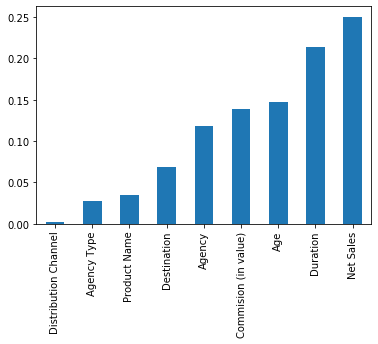

In [56]:
def rfc_feature_selection(dataset,target):
    X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.3, random_state=42, stratify=target)
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    rfc_importances = pd.Series(rfc.feature_importances_, index=dataset.columns).sort_values().tail(10)
    rfc_importances.plot(kind='bar')
    plt.show()

rfc_feature_selection(X,y)

In [58]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def grid_search_random_forrest(dataframe,target):

    x_train,x_val,y_train,y_val = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)
    rfc = RandomForestClassifier()
    param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }
    grid_search_model = GridSearchCV(rfc, param_grid=param_grid)
    grid_search_model.fit(x_train, y_train)
    print('Best Parameters are:')
    return grid_search_model.best_params_


grid_search_random_forrest(X,y)

Best Parameters are:


{'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt'}

Precision Score:
0.48663101604278075
On Validation data
ROC_AUC_SCORE is 0.8300037825339184
              precision    recall  f1-score   support

           0       0.96      0.82      0.89     13081
           1       0.49      0.84      0.62      2612

    accuracy                           0.83     15693
   macro avg       0.72      0.83      0.75     15693
weighted avg       0.88      0.83      0.84     15693



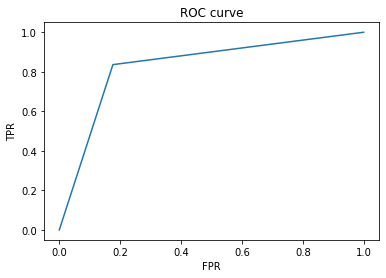

In [69]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE


def grid_search_random_forrest_best(dataframe,target):
    
    
    x_train,x_val,y_train,y_val = train_test_split(dataframe,target, test_size=0.3, random_state=42)
    
    # Applying Smote on train data for dealing with class imbalance
    smote = SMOTE()
    X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
    
    rfc = RandomForestClassifier(n_estimators=10, max_features='sqrt', max_depth=8, criterion='gini',random_state=42)
    rfc.fit(X_sm, y_sm)
    y_pred = rfc.predict(x_val)

    ps = precision_score(y_val, y_pred)
    print('Precision Score:')
    print(ps)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
    print('On Validation data')
    print('ROC_AUC_SCORE is',roc_auc_score(y_val, y_pred))
    print(classification_report(y_val, y_pred))
    #fpr, tpr, _ = roc_curve(y_test, predictions[:,1])
    plt.clf()
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    



grid_search_random_forrest_best(X,y)